# EDA for Project Group #27
#### Clara Richter, Elise Rust, Yujia Jin
##### ANLY 502
##### Project Deliverable #1
#####Nov 9, 2022

#### Business Questions:

##### EDA Questions:
1. Business question: How will we measure “engagement” on Reddit? In what ways do people interact with a post?
- Technical proposal: We will categorize “engagement” as upvotes/downvotes and number of comments. The more of these interactions a post has, the more engagement it has received. We will measure these interactions by using pushshift.io Reddit API to call the variables num_comments and score.

2. Business question: When are the best times to post on Reddit to get the most engagement?
- Technical proposal: We will measure the best times to post on Reddit by using pushshift.io Reddit API to call the created_utc variable. We will order the Reddit posts by most engagement to least engagement and plot the created_utc variable. This will allow us to observe the best times to post on Reddit to get the most engagement.

3. Business question: How long should a Reddit title be to get the most engagement? How many sentences, words, or length of words?
- Technical proposal: We will use the pushshift.io Reddit API to call the title variable to get the text (string) of the post. We will use NLP to count the number of sentences in each post, count the number of words in each post, and count the lengths of the words in each post. We will then order the Reddit posts by most engagement to least engagement and these counts to observe how the length of a post on Reddit leads to engagement. 

##### NLP Questions:
4. Business Question: Which subreddits produce the most/least negative discourse in their comments? In their titles?
- Technical Approach: Extracting text from both titles and comments on Reddit posts, we use the pretrained Spark NLP John Snow Labs Sentiment Classifier from Twitter to classify sentiment of this text. By grouping sentiment by subreddit we can visualize the distribution of positive, negative, and neutral text by subreddit across titles and comments.

5. Business question:  Which topics are correlated to the highest rates of negative sentiment and/or polarization?
- Technical Approach: Extracting text from both titels and comments on Reddit posts, and using the same sentiment analysis from question #4, we can then group sentiment by topic. Topic is generated via regex commands to encompass 4 different political topics, such as 'climate' and the 'economy.'

6. Business question: Do posts with positive, negative, or neutral sentiment receive the most engagement on Reddit?
- Technical Approach: Extracting the same sentiment analysis from previous questions, we draw on number of comments and votes of post to draw connections between sentiment and engagement.

7. Business question: Do posts with positive, negative, or neutral sentiment receive the most engagement on Reddit?
- Technical Approach: Extracting the same sentiment analysis from previous questions, we draw on number of comments and votes of post to draw connections between sentiment and engagement.

8. Business question: How does the economy influence political sentiment? When KPIs (Key Performance Indicators) like unemployment rate are high, how does that affect the types of media and comments that are commonly posted?
- Technical Approach: Using an externally web-scraped dataset of key performance indicators like the DOW index, Consumer Price Index, and Unemployment Rate, we compare political sentiment across time and map trends to economic fluctuations.

##### ML Questions:

9. Business question: Can we predict the state of the economy via KPIs based on text sentiment across 3 political subreddits?
- Technical Approach: We build, train, and test 2 regression models: Decision Tree Regressor and Gradient Boosted Tree Regressor, to predict DOW index from TFIDF-vectorized text data. After hyperparameter tuning, we evaluate and compare results to select the highest performing model.

10. Business question: Can we classify the text of posts and comments into their correct political subreddit? How different is political discourse across all three subreddit communities?
- Technical Approach: We build, train, and test 3 classification models: 2 Random Forest models with different hyperparameter sets that classify comment data and 1 RF model that classifies title data, to classify text data into 3 political subreddits. After hyperparameter tuning, we evaluate and compare results to select the highest performing model.

### Task 1) Data Loading

##### 1A. Load in full Reddit parquet files (for both comments file and submissions file)

In [0]:
dbutils.fs.ls("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet")

Out[3]: [FileInfo(path='abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments/', name='comments/', size=0, modificationTime=1666557328000),
 FileInfo(path='abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions/', name='submissions/', size=0, modificationTime=1666559745000)]

In [0]:
comments = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments")
submissions = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions")

##### 1B. Create directories to store and save data/plots

In [0]:
## create a directory called data/plots and data/csv to save generated data
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

### Task 2. Cleaning and joining dataframes

##### 2A. Filter datasets for relevant subreddits.
###### Our primary business questions are in regards to political content and engagement thus our subreddits of choice are: r/politics, r/Republican, and r/democrats

In [0]:
from pyspark.sql.functions import col, asc,desc
submissions_politics = submissions.filter(submissions.subreddit == "politics")
submissions_Republican = submissions.filter(submissions.subreddit == "Republican")
submissions_democrats = submissions.filter(submissions.subreddit == "democrats")

In [0]:
print(submissions_politics.count())
print(submissions_Republican.count())
print(submissions_democrats.count())

331866
55591
29307


In [0]:
comments_politics = comments.filter(comments.subreddit == "politics")
comments_Republican = comments.filter(comments.subreddit == "Republican")
comments_democrats = comments.filter(comments.subreddit == "democrats")

##### 2B. The 'body' column in comments contains some deleted or removed comments. We are interested in the text from the 'body' column, so we remove these rows because they do not have text to analyze. We want to sample from each of these subreddits to create dataframes of equal size --> thus, we filter out these 'removed' rows beforehand.

In [0]:
# drop the rows with [removed]
comments_politics = comments_politics[comments_politics['body'] != '[removed]']
comments_Republican = comments_Republican[comments_Republican['body'] != '[removed]']
comments_democrats = comments_democrats[comments_democrats['body'] != '[removed]']

# drop the rows with [deleted]
comments_politics = comments_politics[comments_politics['body'] != '[deleted]']
comments_Republican = comments_Republican[comments_Republican['body'] != '[deleted]']
comments_democrats = comments_democrats[comments_democrats['body'] != '[deleted]']

##### 2C. Filter for first level comments (i.e. where 'link_id'=='parent_id' and remove comments ON other comments)

We did this as each submission has dozens of comments, of varying length and importance, so by filtering for each first level comments we extract immediate reactions and sentiments about original texts.

In [0]:
# only rows where link_id and parent_id are equal
comments_politics = comments_politics[comments_politics['link_id'] == comments_politics['parent_id']]
comments_Republican = comments_Republican[comments_Republican['link_id'] == comments_Republican['parent_id']]
comments_democrats = comments_democrats[comments_democrats['link_id'] == comments_democrats['parent_id']]

##### 2D. Select only the relevant variables for our analysis.  
'author' - can check which users are most active.  
'body' - use for NLP.  
'created_utc' - use for time analysis.  
'link_id' - use to link comments to submission posts.  
'score' - use to determine engament of comment.  
'subreddit' - use to group by subreddit.

In [0]:
# select variables
com_pol_filtered = comments_politics.select('author',
'body',
'created_utc',
'link_id',
'score',
'subreddit')

com_Rep_filtered = comments_Republican.select('author',
'body',
'created_utc',
'link_id',
'score',
'subreddit')

com_dem_filtered = comments_democrats.select('author',
'body',
'created_utc',
'link_id',                              
'score',
'subreddit')

In [0]:
com_dem_filtered.show()

+-------------------+--------------------+-----------+---------+-----+---------+
|             author|                body|created_utc|  link_id|score|subreddit|
+-------------------+--------------------+-----------+---------+-----+---------+
|   Eggs_and_Hashing|I don't want you ...| 1624431505|t3_o2tarw|    1|democrats|
|ChristmasTreeFarmer|Can we just fucki...| 1624432929|t3_o5zxel|    8|democrats|
|       Mitchboy1995|            Jesus...| 1624434138|t3_o629iw|    2|democrats|
|          ajamesc55|For federal elect...| 1624441011|t3_o5zo46|    2|democrats|
|          SukiSaito|Must be so tough ...| 1624441445|t3_o64gdv|    0|democrats|
|          SukiSaito|I doubt if they c...| 1624441533|t3_o66ske|    0|democrats|
|             pgm_01|I am actually beg...| 1624441917|t3_o5zo46|    4|democrats|
|           darmabum|&gt;Last month th...| 1615719935|t3_m4qcwu|    3|democrats|
|         decaturbob|filibusters stops...| 1615720786|t3_m4lwvd|    5|democrats|
|         decaturbob|all rac

##### 2E. Join different comments subreddits dataframes together

In [0]:
# join all
com_all = com_pol_filtered.union(com_Rep_filtered)
com_all = com_all.union(com_dem_filtered)

In [0]:
# remove "t3_" from link_id so it can match the id of the submission post
from pyspark.sql import functions as F
com_all = com_all.withColumn("link_id", F.regexp_replace("link_id", "t3_", ""))


##### 2F. Remove rows that have ['deleted by user'] as the title in submissions dataframe

These rows contain no text to build an NLP or ML model on so we remove them

In [0]:
# drop the rows with [deleted by user]
submissions_politics = submissions_politics[submissions_politics['title'] != '[deleted by user]']
submissions_Republican = submissions_Republican[submissions_Republican['title'] != '[deleted by user]']
submissions_democrats = submissions_democrats[submissions_democrats['title'] != '[deleted by user]']

##### 2G. Sample from each subreddit (20,000 rows) to get equal row counts across all three

In [0]:
# 20,000 each
from pyspark.sql.functions import rand

n = 20000

sub_politics = submissions_politics.orderBy(rand()).limit(n)
sub_Republican = submissions_Republican.orderBy(rand()).limit(n)
sub_democrats = submissions_democrats.orderBy(rand()).limit(n)

##### 2H. Join different submissions subreddits dataframes together

In [0]:
# join all
sub_all = sub_politics.union(sub_Republican)
sub_all = sub_all.union(sub_democrats)

In [0]:
# Select relevant columns for analysis
### 'Subreddit' is our label for what subreddit each text came from, 'title' is important for text analysis, 'score and num_comments' are important for analysis regarding engagement/sentiment, 'created_utc' is important for timeseries analysis, and 'id' is relevant for joining the comments and submissions dataframes together.
sub_all_filtered = sub_all.select(
    "subreddit",
    "title",
    "score",
    "num_comments",
    "created_utc",
    "id")

In [0]:
# Save the cleaned submissions dataframe to DBFS
#sub_all_filtered.write.format('com.databricks.spark.csv').save("/FileStore/sub_all_filtered")

In [0]:
## Get list of ids in submissions dataframe --> relevant for joining with comments ids
# We only want comments that are connected to a submissions post
post_id = sub_all_filtered.select("id").rdd.flatMap(lambda x: x).collect()
post_id

Out[50]: ['kvn7ss',
 'o9u5nn',
 'mkes73',
 'qonmla',
 'nk0gtv',
 'kxui58',
 'md3b6y',
 'opjrv1',
 'rc7naa',
 'tb50qx',
 'mpt35w',
 'o1q5dv',
 'q8s7wl',
 'oofjbq',
 'kvfz5e',
 'nmfeh8',
 'oiziqe',
 'li5lwf',
 'l5jnwe',
 't2c09f',
 's8rgrw',
 'p15qnu',
 'w8bead',
 's0ty0s',
 'vjv8xq',
 'ox0uly',
 'ur9vwo',
 'mqyrlb',
 'ncmg58',
 'mmvccw',
 'ql6g39',
 'nb5co3',
 'kxgcew',
 's39zvh',
 'nb1457',
 'pewgga',
 'lsrafy',
 'lsy15x',
 'm8w3rh',
 'uhu4o5',
 'lj8ymp',
 'tb9hgs',
 'ks4pgg',
 'l83qjc',
 'lkbr80',
 'wpalzi',
 'lc77fr',
 'p886t7',
 'n21ix1',
 'pakoqi',
 'lc7op5',
 'n14uqn',
 'wpomdl',
 'p8c4ea',
 'kxmpik',
 'q7indi',
 'pulbzl',
 'pl7k3n',
 'md248n',
 'ou3kmk',
 'l4oqu4',
 'pq3zak',
 'mzsrb0',
 'lazrav',
 'nda101',
 'ujrms9',
 'oe711v',
 'vc4s2z',
 'kw1ma5',
 'kv892k',
 'vxq3yd',
 'pfdhzm',
 'rit6g1',
 'kt8cwf',
 'pix35a',
 't14l0j',
 'mm49ki',
 'kwqbs1',
 'sjqyq5',
 'tgzemh',
 'ns3nru',
 'li5wig',
 'q3p93b',
 'pip01r',
 'obtq9z',
 'qxsohv',
 'q5f2hk',
 'tg9ec1',
 't6rh0d',
 'o1566o',
 

In [0]:
# Keep only comments rows where link_id is in post_id list
com_all_new = com_all.filter((com_all['link_id']).isin(post_id))

In [0]:
### Prepare comments dataframe for join: Deal with duplicate column names across two dfs

# add "com_" to all column names in com_all dataframe
com_all_new = com_all_new.select([F.col(c).alias("com_"+c) for c in com_all_new.columns])

### Task 3: Join comments and submissions dataframes

In [0]:
sub_com = sub_all.join(com_all_new, sub_all._c5 ==  com_all_new.com_link_id, "left")

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-3912222683746846> in <cell line: 1>()
----> 1 sub_com = sub_all.join(com_all_new, sub_all._c5 ==  com_all_new.com_link_id, "left")

/databricks/python/lib/python3.9/site-packages/pandas/core/generic.py in __getattr__(self, name)
   5485         ):
   5486             return self[name]
-> 5487         return object.__getattribute__(self, name)
   5488 
   5489     def __setattr__(self, name: str, value) -> None:

AttributeError: 'DataFrame' object has no attribute '_c5'

In [0]:
# Save joined submissions+comments dataframe to DBFS
#sub_com.write.format('com.databricks.spark.csv').save("/FileStore/sub_com")

### Task 4: Conduct basic EDA on joined dataframes

In [0]:
### Read in joined submissions+comments dataframe from DBFS
sub_com = spark.read.csv("/data/csv/sub_com.csv", header=False)
sub_com

Out[55]: DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string]

In [0]:
import pandas as pd

## Individual comments and submissions dataframes available for dataloading
# Read in submissions only dataframe for EDA
sub_all= spark.read.csv("/FileStore/sub_all_filtered", header=False)
sub_all = sub_all.toPandas()
sub_all

,_c0,_c1,_c2,_c3,_c4,_c5
0,politics,Ocasio-Cortez says Trump's Georgia call is an ...,5,2,1609715137,kpvcuy
1,politics,Minneapolis endures more unrest after deputies...,1,2,1622926342,nt53b1
2,politics,Cleveland Clinic Study Shows No Benefit From V...,1,0,1623275299,nw7amm
3,politics,Whistleblower featured in USA TODAY 'Behind th...,158,30,1637082453,qvckuy
4,politics,Biden stopped building Trump's wall.,1,3,1619848164,n2ca05
...,...,...,...,...,...,...
59995,democrats,"Exclusive audio: Trump defends threats to ""han...",498,41,1636717395,qs9f1w
59996,democrats,Demand Congress Pass the H.R. 1 For the People...,8,2,1611252887,l241qc
59997,democrats,Any Republican President you think was good?,9,23,1615187436,m0a931
59998,democrats,U.S. sanctions Guatemala's attorney general ov...,4,0,1652824927,urxmam


In [0]:
### Rename columns of sub_all
sub_all.rename(columns={'_c0':'subreddit', '_c1':'title', '_c2':'score', '_c3':'num_comments', '_c4':'created_utc', '_c5':'id'}, inplace=True)
sub_all

,subreddit,title,score,num_comments,created_utc,id
0,politics,Ocasio-Cortez says Trump's Georgia call is an ...,5,2,1609715137,kpvcuy
1,politics,Minneapolis endures more unrest after deputies...,1,2,1622926342,nt53b1
2,politics,Cleveland Clinic Study Shows No Benefit From V...,1,0,1623275299,nw7amm
3,politics,Whistleblower featured in USA TODAY 'Behind th...,158,30,1637082453,qvckuy
4,politics,Biden stopped building Trump's wall.,1,3,1619848164,n2ca05
...,...,...,...,...,...,...
59995,democrats,"Exclusive audio: Trump defends threats to ""han...",498,41,1636717395,qs9f1w
59996,democrats,Demand Congress Pass the H.R. 1 For the People...,8,2,1611252887,l241qc
59997,democrats,Any Republican President you think was good?,9,23,1615187436,m0a931
59998,democrats,U.S. sanctions Guatemala's attorney general ov...,4,0,1652824927,urxmam


##### Basic Data Cleaning

Remove extraneous columns, rename columns

In [0]:
# Convert to Pandas DF
sub_com_df = sub_com.toPandas()
sub_com_df

,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13
0,Republican,14+ Minute Eulogy Joe Biden Gave at Strom Thur...,1,0,1609463277,ko24lf,None,None,None,None,None,None,None,None
1,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,Sinical89,"First hiding from debate, now hiding from runo...",1609475304,ghobxm0,false,ko2wqc,2,politics
2,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,ilovechairs,Ol’ Sleepy David hiding in his basement. Low E...,None,None,None,None,None,None
3,"Sound like a tweet I’ve read.""",1609479629,ghohh8i,false,ko2wqc,1,politics,None,None,None,None,None,None,None
4,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,barneyrubbble,"Ah. That would be called the old ""hiding in th...",1609469205,gho386z,false,ko2wqc,29,politics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005972,To those visiting this thread,we ask that unless you identify as Republican...,None,None,None,None,None,None,None,None,None,None,None,None
1005973,*I am a bot,and this action was performed automatically. ...,1661554076,ilxjxxv,false,wymlmb,1,Republican,None,None,None,None,None,None
1005974,Republican,New Subreddit to help STOP Biden's Student Loa...,1,2,1661833570,x19l38,AutoModerator,/r/Republican is a partisan subreddit. This i...,None,None,None,None,None,None
1005975,To those visiting this thread,we ask that unless you identify as Republican...,None,None,None,None,None,None,None,None,None,None,None,None


In [0]:
### Rename columns
sub_com_df.rename(columns={'_c0':'subreddit', '_c1':'title', '_c2':'score', '_c3':'num_comments', '_c4':'created_utc', '_c5':'id', '_c6':'username', '_c7':'body', '_c8':'com_created_utc', '_c9':'com_id', '_c10':'com_score', '_c11':'com_subreddit'}, inplace=True)
sub_com_df

,subreddit,title,score,num_comments,created_utc,id,username,body,com_created_utc,com_id,com_score,com_subreddit,_c12,_c13
0,Republican,14+ Minute Eulogy Joe Biden Gave at Strom Thur...,1,0,1609463277,ko24lf,None,None,None,None,None,None,None,None
1,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,Sinical89,"First hiding from debate, now hiding from runo...",1609475304,ghobxm0,false,ko2wqc,2,politics
2,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,ilovechairs,Ol’ Sleepy David hiding in his basement. Low E...,None,None,None,None,None,None
3,"Sound like a tweet I’ve read.""",1609479629,ghohh8i,false,ko2wqc,1,politics,None,None,None,None,None,None,None
4,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,barneyrubbble,"Ah. That would be called the old ""hiding in th...",1609469205,gho386z,false,ko2wqc,29,politics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005972,To those visiting this thread,we ask that unless you identify as Republican...,None,None,None,None,None,None,None,None,None,None,None,None
1005973,*I am a bot,and this action was performed automatically. ...,1661554076,ilxjxxv,false,wymlmb,1,Republican,None,None,None,None,None,None
1005974,Republican,New Subreddit to help STOP Biden's Student Loa...,1,2,1661833570,x19l38,AutoModerator,/r/Republican is a partisan subreddit. This i...,None,None,None,None,None,None
1005975,To those visiting this thread,we ask that unless you identify as Republican...,None,None,None,None,None,None,None,None,None,None,None,None


In [0]:
### Drop duplicate or extraneous columns
# All three columns are either irrelevant to analysis or already contained in other columns
sub_com_df = sub_com_df.drop(columns=['com_subreddit', 'com_id'])
sub_com_df

,subreddit,title,score,num_comments,created_utc,id,username,body,com_created_utc,com_score,_c12,_c13
0,Republican,14+ Minute Eulogy Joe Biden Gave at Strom Thur...,1,0,1609463277,ko24lf,None,None,None,None,None,None
1,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,Sinical89,"First hiding from debate, now hiding from runo...",1609475304,false,2,politics
2,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,ilovechairs,Ol’ Sleepy David hiding in his basement. Low E...,None,None,None,None
3,"Sound like a tweet I’ve read.""",1609479629,ghohh8i,false,ko2wqc,1,politics,None,None,None,None,None
4,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,barneyrubbble,"Ah. That would be called the old ""hiding in th...",1609469205,false,29,politics
...,...,...,...,...,...,...,...,...,...,...,...,...
1005972,To those visiting this thread,we ask that unless you identify as Republican...,None,None,None,None,None,None,None,None,None,None
1005973,*I am a bot,and this action was performed automatically. ...,1661554076,ilxjxxv,false,wymlmb,1,Republican,None,None,None,None
1005974,Republican,New Subreddit to help STOP Biden's Student Loa...,1,2,1661833570,x19l38,AutoModerator,/r/Republican is a partisan subreddit. This i...,None,None,None,None
1005975,To those visiting this thread,we ask that unless you identify as Republican...,None,None,None,None,None,None,None,None,None,None


##### 4A. Report on basic info of data (schema, row numbers, etc.)

We're going to plot and examine both the joined submissions+comments dataframes as well as just the submissions dataframe so data cleaning and exploration will happen for both.

In [0]:
# Check the datatype of columns
#sub_all.drop(sub_all.columns[0], axis=1)
for col in sub_all.columns:
    print(col, sub_all[col].dtype)

subreddit object
title object
score object
num_comments object
created_utc object
id object


In [0]:
for col in sub_com_df.columns:
    print(col, sub_com_df[col].dtype)

subreddit object
title object
score object
num_comments object
created_utc object
id object
username object
body object
com_created_utc object
com_score object
_c12 object
_c13 object


In [0]:
print("Number of submissions rows: ", len(sub_all)) # Get number of rows in the submissions dataframe
print("Number of submissions+comments rows: ", len(sub_com_df)) # Get number of rows in the joined dataframe

Number of submissions rows:  60000
Number of submissions+comments rows:  1005977


##### 4B. Conduct basic quality checks (null values, datatype conversions, dealing with outliers)

In [0]:
# change 'subreddit' column to categorical variable
sub_all["subreddit"] = sub_all["subreddit"].astype("category")
sub_com_df["subreddit"] = sub_com_df["subreddit"].astype("category")

In [0]:
# change to numeric variables
sub_all["score"] = sub_all["score"].astype(int)
sub_all["num_comments"] = sub_all["num_comments"].astype(int)
#sub_com_df["score"] = sub_com_df["score"].astype(int)

In [0]:
# check for missing values
print("Missing values in submissions")
print(sub_all.isnull().sum())
print(" ")
print("Missing values in joined df")
print(sub_com_df.isnull().sum())

Missing values in submissions
subreddit       0
title           0
score           0
num_comments    0
created_utc     0
id              0
dtype: int64
 
Missing values in joined df
subreddit              11
title              102455
score              172152
num_comments       183434
created_utc        190603
id                 193514
username           209749
body               284720
com_created_utc    492211
com_score          510751
_c12               513272
_c13               513744
dtype: int64


So there are no missing values in the submissions dataframe --> but hundreds of thousands in the joined dataframe!

This is due to the nature of the df as there are many comments per submission. We've decided not to remove these rows as they may contain valuable information for our analysis. When we get to feature extraction and NLP/ML models we want as much data as possible, so we will remove duplicates and deal with null values for specific tasks at that point.

##### 4C. Convert columns to proper datatypes

In [0]:
# Convert the time variable to proper datetime type
sub_all['time'] = pd.to_datetime(sub_all['created_utc'],unit='s')
sub_all

,subreddit,title,score,num_comments,created_utc,id,time
0,politics,Ocasio-Cortez says Trump's Georgia call is an ...,5,2,1609715137,kpvcuy,2021-01-03 23:05:37
1,politics,Minneapolis endures more unrest after deputies...,1,2,1622926342,nt53b1,2021-06-05 20:52:22
2,politics,Cleveland Clinic Study Shows No Benefit From V...,1,0,1623275299,nw7amm,2021-06-09 21:48:19
3,politics,Whistleblower featured in USA TODAY 'Behind th...,158,30,1637082453,qvckuy,2021-11-16 17:07:33
4,politics,Biden stopped building Trump's wall.,1,3,1619848164,n2ca05,2021-05-01 05:49:24
...,...,...,...,...,...,...,...
59995,democrats,"Exclusive audio: Trump defends threats to ""han...",498,41,1636717395,qs9f1w,2021-11-12 11:43:15
59996,democrats,Demand Congress Pass the H.R. 1 For the People...,8,2,1611252887,l241qc,2021-01-21 18:14:47
59997,democrats,Any Republican President you think was good?,9,23,1615187436,m0a931,2021-03-08 07:10:36
59998,democrats,U.S. sanctions Guatemala's attorney general ov...,4,0,1652824927,urxmam,2022-05-17 22:02:07


In [0]:
## Convert created_utc columns to dates in sub_com_df as well
import numpy as np

sub_com_df["created_utc"].value_counts()
### For all 'created_utc' values of 0, the date gets generated as '1970-01-01 00:00'. These are useless so will be replaced with NAs.

## For non-integer values (i.e. corrupted values) --> replace with NAs
sub_com_df["created_utc"] = pd.to_numeric(sub_com_df.created_utc, errors='coerce').fillna(0).astype(int)
sub_com_df["com_created_utc"] = pd.to_numeric(sub_com_df.com_created_utc, errors='coerce').fillna(0).astype(int)

sub_com_df['submission_time'] = pd.to_datetime(sub_com_df['created_utc'],unit='s')
sub_com_df['comment_time'] = pd.to_datetime(sub_com_df['com_created_utc'],unit='s')

# Replace '1970-01-01 00:00' with NAs
sub_com_df.replace('1970-01-01 00:00:00', np.nan)

sub_com_df

## Print outcome and drop old time columns
#sub_com_df.drop(columns=["created_utc", "com_created_utc"])

,subreddit,title,score,num_comments,created_utc,id,username,body,com_created_utc,com_score,_c12,_c13,submission_time,comment_time
0,Republican,14+ Minute Eulogy Joe Biden Gave at Strom Thur...,1,0,1609463277,ko24lf,None,None,0,None,None,None,2021-01-01 01:07:57,1970-01-01 00:00:00
1,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,Sinical89,"First hiding from debate, now hiding from runo...",1609475304,false,2,politics,2021-01-01 01:59:57,2021-01-01 04:28:24
2,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,ilovechairs,Ol’ Sleepy David hiding in his basement. Low E...,0,None,None,None,2021-01-01 01:59:57,1970-01-01 00:00:00
3,"Sound like a tweet I’ve read.""",1609479629,ghohh8i,false,0,1,politics,None,0,None,None,None,1970-01-01 00:00:00,1970-01-01 00:00:00
4,politics,Senator David Perdue Quarantining After COVID ...,279,45,1609466397,ko2wqc,barneyrubbble,"Ah. That would be called the old ""hiding in th...",1609469205,false,29,politics,2021-01-01 01:59:57,2021-01-01 02:46:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005972,To those visiting this thread,we ask that unless you identify as Republican...,None,None,0,None,None,None,0,None,None,None,1970-01-01 00:00:00,1970-01-01 00:00:00
1005973,*I am a bot,and this action was performed automatically. ...,1661554076,ilxjxxv,0,wymlmb,1,Republican,0,None,None,None,1970-01-01 00:00:00,1970-01-01 00:00:00
1005974,Republican,New Subreddit to help STOP Biden's Student Loa...,1,2,1661833570,x19l38,AutoModerator,/r/Republican is a partisan subreddit. This i...,0,None,None,None,2022-08-30 04:26:10,1970-01-01 00:00:00
1005975,To those visiting this thread,we ask that unless you identify as Republican...,None,None,0,None,None,None,0,None,None,None,1970-01-01 00:00:00,1970-01-01 00:00:00


##### 4D. Feature generations

Create 5 new relevant variables for analysis with data transformations as well as 3 dummy variables using regex.

In [0]:
## Create new month, year, and time of day variables
sub_all['year'] = (pd.Series(pd.DatetimeIndex(sub_all['time']).year)).values
sub_all['month'] = (pd.Series(pd.DatetimeIndex(sub_all['time']).month)).values
sub_all['hour'] = (pd.Series(pd.DatetimeIndex(sub_all['time']).hour)).values
sub_all['time_of_day'] = pd.cut(sub_all['hour'], bins=[0, 6, 12, 18, 23], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

sub_com_df['sub_year'] = (pd.Series(pd.DatetimeIndex(sub_com_df['submission_time']).year)).values
sub_com_df['sub_month'] = (pd.Series(pd.DatetimeIndex(sub_com_df['submission_time']).month)).values
sub_com_df['sub_hour'] = (pd.Series(pd.DatetimeIndex(sub_com_df['submission_time']).hour)).values
sub_com_df['sub_time_of_day'] = pd.cut(sub_com_df['sub_hour'], bins=[0, 6, 12, 18, 23], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

## View new time variables
print(sub_all[["year", "month", "hour", "time_of_day"]])
print(sub_com_df[["sub_year", "sub_month", "sub_hour", "sub_time_of_day"]])

       year  month  hour time_of_day
0      2021      1    23     Evening
1      2021      6    20     Evening
2      2021      6    21     Evening
3      2021     11    17   Afternoon
4      2021      5     5       Night
...     ...    ...   ...         ...
59995  2021     11    11     Morning
59996  2021      1    18   Afternoon
59997  2021      3     7     Morning
59998  2022      5    22     Evening
59999  2021      9    15   Afternoon

[60000 rows x 4 columns]
         sub_year  sub_month  sub_hour sub_time_of_day
0            2021          1         1           Night
1            2021          1         1           Night
2            2021          1         1           Night
3            1970          1         0             NaN
4            2021          1         1           Night
...           ...        ...       ...             ...
1005972      1970          1         0             NaN
1005973      1970          1         0             NaN
1005974      2022          8       

In [0]:
# Check for unique values in new 'hour' column
sub_all['hour'].unique()

Out[70]: array([23, 20, 21, 17,  5, 16, 10, 22,  1,  9,  3,  0, 12,  4,  2, 14, 15,
       19,  6,  8,  7, 11, 18, 13])

In [0]:
# View binned time of day variable - does it capture all 4 time periods?
print(sub_all['time_of_day'].unique())

['Evening', 'Afternoon', 'Night', 'Morning', NaN]
Categories (4, object): ['Night' < 'Morning' < 'Afternoon' < 'Evening']


In [0]:
# Create 'title_length' variable to calculate length of title and 'comment_length' to calcualte length of comment
sub_all["title_length"] = sub_all['title'].apply(len)

sub_com_df["title_length"] =  (sub_com_df[sub_com_df["title"].notnull()])["title"].apply(len)
sub_com_df["comment_length"] = (sub_com_df[sub_com_df["body"].notnull()])["body"].apply(len)

# View output
print(sub_com_df[["title_length", "comment_length"]])

         title_length  comment_length
0                60.0             NaN
1                54.0            58.0
2                54.0            82.0
3                10.0             NaN
4                54.0            88.0
...               ...             ...
1005972         400.0             NaN
1005973         172.0            10.0
1005974          77.0           114.0
1005975         400.0             NaN
1005976         172.0            10.0

[1005977 rows x 2 columns]


In [0]:
## Create 1 more variable:
# election_year (T/F) with T for year == 2022 because dataset only runs from 2021 onwards
sub_all["year"].min() # 2021
sub_all["year"].max() # 2022
sub_all["election_year"] = np.where(sub_all["year"]==2022, True, False)
sub_all

,subreddit,title,score,num_comments,created_utc,id,time,year,month,hour,time_of_day,title_length,election_year
0,politics,Ocasio-Cortez says Trump's Georgia call is an ...,5,2,1609715137,kpvcuy,2021-01-03 23:05:37,2021,1,23,Evening,65,False
1,politics,Minneapolis endures more unrest after deputies...,1,2,1622926342,nt53b1,2021-06-05 20:52:22,2021,6,20,Evening,64,False
2,politics,Cleveland Clinic Study Shows No Benefit From V...,1,0,1623275299,nw7amm,2021-06-09 21:48:19,2021,6,21,Evening,131,False
3,politics,Whistleblower featured in USA TODAY 'Behind th...,158,30,1637082453,qvckuy,2021-11-16 17:07:33,2021,11,17,Afternoon,90,False
4,politics,Biden stopped building Trump's wall.,1,3,1619848164,n2ca05,2021-05-01 05:49:24,2021,5,5,Night,36,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,democrats,"Exclusive audio: Trump defends threats to ""han...",498,41,1636717395,qs9f1w,2021-11-12 11:43:15,2021,11,11,Morning,54,False
59996,democrats,Demand Congress Pass the H.R. 1 For the People...,8,2,1611252887,l241qc,2021-01-21 18:14:47,2021,1,18,Afternoon,95,False
59997,democrats,Any Republican President you think was good?,9,23,1615187436,m0a931,2021-03-08 07:10:36,2021,3,7,Morning,44,False
59998,democrats,U.S. sanctions Guatemala's attorney general ov...,4,0,1652824927,urxmam,2022-05-17 22:02:07,2022,5,22,Evening,84,True


In [0]:
#### Create dummy variables about topics using regex commands
import re

## 1) police
sub_all["dummy_police"] = sub_all.title.str.contains(r'(?=.*police)|(?=.*law)|(?=.*enforcement)|(?=.*brutality)|(?=.*order)')
sub_com_df["dummy_police"] = sub_com_df.title.str.contains(r'(?=.*police)|(?=.*law)|(?=.*enforcement)|(?=.*brutality)|(?=.*order)')

## 2) healthcare
sub_all["dummy_healthcare"] = sub_all.title.str.contains(r'(?=.*health)|(?=.*insur)|(?=.*pharma)|(?=.*diagnos)|(?=.*medicine)|(?=.*vaccin)')
sub_com_df["dummy_healthcare"] = sub_com_df.title.str.contains(r'(?=.*health)|(?=.*insur)|(?=.*pharma)|(?=.*diagnos)|(?=.*medicine)|(?=.*vaccin)')

## 3) climate
sub_all["dummy_climate"] = sub_all.title.str.contains(r'(?=.*climate)|(?=.*energy)|(?=.*renewable)|(?=.*deforest)|(?=.*global warming)')
sub_com_df["dummy_climate"] = sub_com_df.title.str.contains(r'(?=.*climate)|(?=.*energy)|(?=.*renewable)|(?=.*deforest)|(?=.*global warming)')

## 4) taxes
sub_all["dummy_economy"] = sub_all.title.str.contains(r'(?=.*tax)|(?=.*inflation)|(?=.*economy)|(?=.*costs)|(?=.*unemployment)')
sub_com_df["dummy_economy"] = sub_com_df.title.str.contains(r'(?=.*tax)|(?=.*inflation)|(?=.*economy)|(?=.*costs)|(?=.*unemployment)')

# View new variables
print(sub_all[["title", "dummy_police", "dummy_healthcare", "dummy_climate", "dummy_economy"]])
print(sub_com_df[["title", "dummy_police", "dummy_healthcare", "dummy_climate", "dummy_economy"]])

                                                   title  dummy_police  \
0      Ocasio-Cortez says Trump's Georgia call is an ...         False   
1      Minneapolis endures more unrest after deputies...         False   
2      Cleveland Clinic Study Shows No Benefit From V...         False   
3      Whistleblower featured in USA TODAY 'Behind th...          True   
4                   Biden stopped building Trump's wall.         False   
...                                                  ...           ...   
59995  Exclusive audio: Trump defends threats to "han...         False   
59996  Demand Congress Pass the H.R. 1 For the People...         False   
59997       Any Republican President you think was good?         False   
59998  U.S. sanctions Guatemala's attorney general ov...         False   
59999  This guy is asking for Gavin Newsom accomplish...         False   

       dummy_healthcare  dummy_climate  dummy_economy  
0                 False          False          False  

### Task 5: Generate summary statistics and summary tables for the dataset.
Explore basic summary statistics broken down by *subreddit*, *time_of_day*, *election_year*, and *month*.

In [0]:
### Summary statistics

# Table 1: Summary Statistics broken down by subreddit
table1 = sub_all.groupby(sub_all["subreddit"]).describe()
print(table1)

#table1.to_csv("data/csv/table1.csv")

              score                                                           \
              count        mean          std  min  25%  50%    75%       max   
subreddit                                                                      
Republican  20000.0    46.56315   147.276897  0.0  1.0  6.0   23.0    2826.0   
democrats   20000.0    89.35005   390.803425  0.0  1.0  3.0   30.0   34598.0   
politics    20000.0  1048.14250  5486.177426  0.0  1.0  6.0  166.0  116221.0   

           num_comments            ...  hour       title_length           \
                  count      mean  ...   75%   max        count     mean   
subreddit                          ...                                     
Republican      20000.0   6.50690  ...  19.0  23.0      20000.0  76.8219   
democrats       20000.0  11.23155  ...  19.0  23.0      20000.0  74.2065   
politics        20000.0  89.92075  ...  19.0  23.0      20000.0  81.4552   

                                                     
        

In [0]:
# Table 2: Summary Statistics broken down by time of day
table2 = sub_all.groupby(sub_all["time_of_day"]).describe()
print(table2)

#table2.to_csv("data/csv/table2.csv")

               score                                                           \
               count        mean          std  min  25%  50%    75%       max   
time_of_day                                                                     
Night        11843.0  261.983281  2523.131294  0.0  1.0  2.0  30.00  111262.0   
Morning       7278.0  547.599203  3983.825068  0.0  1.0  3.0  59.75  113834.0   
Afternoon    21326.0  434.887274  3113.719422  0.0  1.0  7.0  59.00   99960.0   
Evening      16738.0  384.970427  3518.108858  0.0  1.0  5.0  44.00  116221.0   

            num_comments             ...  hour       title_length             \
                   count       mean  ...   75%   max        count       mean   
time_of_day                          ...                                       
Night            11843.0  33.967407  ...   4.0   6.0      11843.0  75.105294   
Morning           7278.0  44.079280  ...  12.0  12.0       7278.0  76.802968   
Afternoon        21326.0  36.442

In [0]:
# Table 3: Summary Statistics broken down by election year
table3 = sub_all.groupby(sub_all["election_year"]).describe()
print(table3)

#table3.to_csv("data/csv/table3.csv")

                 score                                                \
                 count        mean          std  min  25%  50%   75%   
election_year                                                          
False          42014.0  392.876375  3236.062928  0.0  1.0  5.0  40.0   
True           17986.0  398.910597  3148.484632  0.0  1.0  5.0  70.0   

                        num_comments             ...  hour       title_length  \
                    max        count       mean  ...   75%   max        count   
election_year                                    ...                            
False          116221.0      42014.0  35.435807  ...  19.0  23.0      42014.0   
True           113834.0      17986.0  36.938953  ...  19.0  23.0      17986.0   

                                                                   
                    mean        std  min   25%   50%   75%    max  
election_year                                                      
False          77.097206  48.

In [0]:
# Table 4: Summary Statistics broken down by month
table4 = sub_all.groupby(sub_all["month"]).describe()
print(table4)

#table4.to_csv("data/csv/table4.csv")

        score                                                           \
        count        mean          std  min  25%  50%    75%       max   
month                                                                    
1      9100.0  595.640220  4710.014873  0.0  1.0  8.0  61.00  116221.0   
2      6210.0  467.643478  3748.447057  0.0  1.0  4.0  43.00  113834.0   
3      6169.0  410.754417  3171.593301  0.0  1.0  4.0  41.00   74864.0   
4      6019.0  380.378302  2901.349585  0.0  1.0  3.0  39.00   72777.0   
5      5903.0  356.510080  2919.363412  0.0  1.0  2.0  36.00   73108.0   
6      5749.0  349.024352  2565.251326  0.0  1.0  4.0  42.00   72722.0   
7      5239.0  283.627601  2330.289218  0.0  1.0  4.0  50.00   77094.0   
8      5364.0  387.289150  2901.206119  0.0  1.0  5.0  61.00   70144.0   
9      2699.0  271.927381  1971.127369  0.0  1.0  9.0  56.00   75336.0   
10     2430.0  302.506996  2420.889761  0.0  1.0  9.0  60.75   79945.0   
11     2545.0  308.011788  2754.810372

### Task 5: Visualizations about our dataset

##### 5A. Data subsetting and cleaning for plotting

In [0]:
# remove the data beyond 99 percentile
sub_all_change_comment = sub_all[sub_all['num_comments'] < sub_all['num_comments'].quantile(0.99)]
sub_all_change_comment['subreddit'].value_counts()

Out[79]: Republican    20000
democrats     19992
politics      19408
Name: subreddit, dtype: int64

In [0]:
republican_df = sub_all_change_comment[sub_all_change_comment['subreddit'] == 'Republican'].sample(n = 19409)
democrats_df = sub_all_change_comment[sub_all_change_comment['subreddit'] == 'democrats'].sample(n = 19409)
sub_all_change_comment = republican_df.append(democrats_df).append(sub_all_change_comment[sub_all_change_comment['subreddit'] == 'politics'])

In [0]:
# prepare dataset for 5B
sub_all_subdf = sub_all_change_comment[['subreddit','hour','num_comments']]
sub_all_gb_hour = sub_all_subdf.groupby(['hour', 'subreddit']).sum()
sub_all_gb_hour = sub_all_gb_hour.reset_index()


In [0]:
# prepare dataset for 5C
sub_all_time = sub_all_change_comment[['subreddit','time_of_day','num_comments']]
sub_all_gb_time = sub_all_time.groupby(['time_of_day', 'subreddit']).sum()
sub_all_gb_time = sub_all_gb_time.reset_index()

In [0]:
# prepare dataset for 5D
republican = sub_all_change_comment[sub_all_change_comment['subreddit'] == 'Republican'].sample(n = 1000)
democrats = sub_all_change_comment[sub_all_change_comment['subreddit'] == 'democrats'].sample(n = 1000)
sub_all_change_size = republican.append(democrats).append(sub_all_change_comment[sub_all_change_comment['subreddit'] == 'politics'].sample(n = 1000))
#sub_all_change_size

In [0]:
sub_all_change_range = sub_all_change_size[(sub_all_change_size['score'] < 2000) & (sub_all_change_size['num_comments'] < 150)]

In [0]:
sub_all_change_size

,subreddit,title,score,num_comments,created_utc,id,time,year,month,hour,time_of_day,title_length,election_year,dummy_police,dummy_healthcare,dummy_climate,dummy_economy
22188,Republican,Democrats’ Burisma Bait and Switch,1,0,1611561493,l4j4zl,2021-01-25 07:58:13,2021,1,7,Morning,34,False,False,False,False,False
38068,Republican,"Amish Farm Fined $250K, Facing Jail Time for H...",179,28,1655474069,vedqc5,2022-06-17 13:54:29,2022,6,13,Afternoon,99,True,False,False,False,False
31183,Republican,"How many Gabbers do we have here? Honestly, it...",1,0,1623905593,o1ov4l,2021-06-17 04:53:13,2021,6,4,Night,100,False,False,False,False,False
21795,Republican,Ron DeSantis To Sign Bill Banning Biological M...,1094,122,1620041639,n3tsib,2021-05-03 11:33:59,2021,5,11,Morning,81,False,False,False,False,False
33120,Republican,MAJESTIC PURE Himalayan Salt Body Scrub with L...,1,1,1654272084,v42l8a,2022-06-03 16:01:24,2022,6,16,Afternoon,138,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13522,politics,House Panel Recommends Contempt Charge Against...,358,16,1634688501,qboidi,2021-10-20 00:08:21,2021,10,0,NaN,53,False,False,False,False,False
989,politics,"Pence defies Trump, says he can't reject elect...",62,5,1609979363,ks18j4,2021-01-07 00:29:23,2021,1,0,NaN,56,False,False,False,False,False
4838,politics,"If you're a Republican, you must announce your...",15,10,1654312881,v4g04k,2022-06-04 03:21:21,2022,6,3,Night,152,True,False,False,False,False
9356,politics,Koch-backed group fuels opposition to school m...,847,60,1633115103,pzese0,2021-10-01 19:05:03,2021,10,19,Evening,79,False,False,False,False,False


In [0]:
# prepare dataset for 5F
sub_all_cnt = sub_all[['subreddit','hour']]
sub_all_cnt = sub_all_cnt.groupby(['hour','subreddit'])['subreddit'].count().to_frame()
sub_all_cnt = sub_all_cnt.rename(columns = {'subreddit':'counts'})
sub_all_cnt = sub_all_cnt.reset_index()

In [0]:
sub_all_cnt['num_comments'] = sub_all_gb_hour['num_comments']
sub_all_cnt['comments_post_ratio'] = sub_all_cnt['num_comments']/sub_all_cnt['counts'] 

##### 5B. Bar Chart of Distribution of Number of Comments against Hour of Post


This graph shows the distribution of sum of number of comments of reddit posts versus hours in a day. These three subreddit share same pattern of fluctuation of number of comments through out the day. The number of comments peaked at afternoon at around 15:00 to 16:00 and stay lowest at morning time, 6:00 to 9:00. The politics subreddit have much more comments than other two subreddits. Overally, democrats subbreddit has more number of comments than republican.

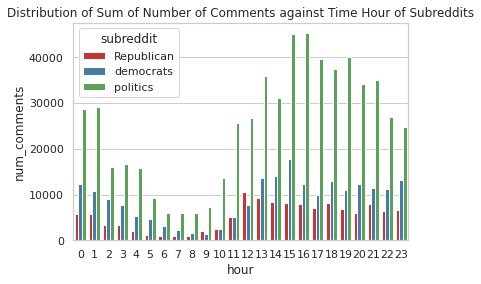

In [0]:
import matplotlib.pyplot as plt
import seaborn  as sns

# BAR CHART
sns.set_theme(style="whitegrid", palette="Set1")
sns.barplot(
    data=sub_all_gb_hour, 
    #kind="bar",
    x="hour", 
    y="num_comments", 
    hue="subreddit").set(title='Distribution of Sum of Number of Comments against Time Hour of Subreddits')

plt.show()
#plt.savefig('data/plots/fig1.png')

##### 5C. Bar Chart of Distribution of Number of Comments against Time of Day of Post

This graph shows the distribution of sum of number of comments of reddit posts versus time of the day. This plot matches the previous one. The sum of number of comments of all three subreddits peaks at afternoon and reach lowest at night and morning.

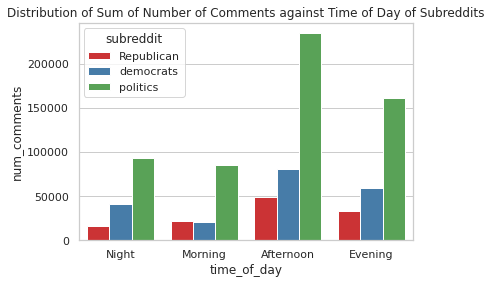

In [0]:
sns.set_theme(style="whitegrid", palette="Set1")
sns.barplot(
    data=sub_all_gb_time, 
    x="time_of_day", 
    y="num_comments", 
    hue="subreddit").set(title='Distribution of Sum of Number of Comments against Time of Day of Subreddits')

plt.show()
#plt.savefig('data/plots/fig2.png')

##### 5D. Scatterplot of post score vs. number of comments

The first graph below has shown the relationship between the score and number of comments of all three subreddit. The dataset used in this plot is the subset of original dataset, 1000 records of each subreddit. The score of most posts lay within the range of 0 to 2000 and the number of comments lay within the range of 0 to 100. Both the score and number of comments of politics subreddits are much more expanded than other two subreddits. The post score has a roughly positive relationship with number of comments. The second graph shows the same two variables with altered range, it shows the same positive relationship between these two variables.

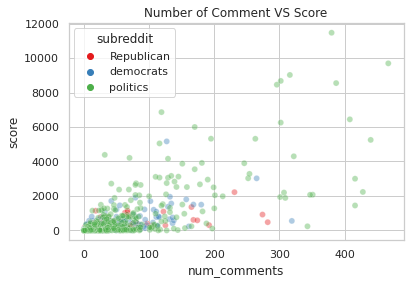

In [0]:
sns.scatterplot(
    data=sub_all_change_size, 
    x='num_comments', 
    y='score',
    hue="subreddit",
    alpha = .4).set(title = 'Number of Comment VS Score')
plt.show()
#plt.savefig('data/plots/fig3.png')

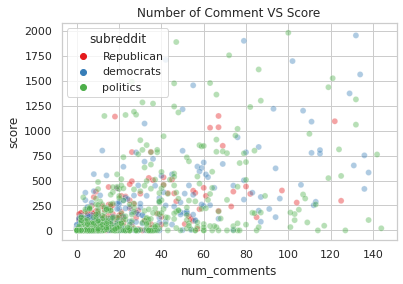

In [0]:
sns.scatterplot(
    data=sub_all_change_range, 
    x='num_comments', 
    y='score',
    hue="subreddit",
    alpha = .4).set(title = 'Number of Comment VS Score')
plt.show()
#plt.savefig('data/plots/fig4.png')

##### 5E. Correlation plot between length of titles and number of comment

This graph has shown the relationship between length of titles and number of comments. The dataset used in this graph is a subset of original dataset, which take 1000 row of each subreddit. According to the graph, the number of comments reaches the peak at around title length of 70 and then decrease after that length. This graph answers the business question 3 'How long should a Reddit title be to get the most engagement?'.

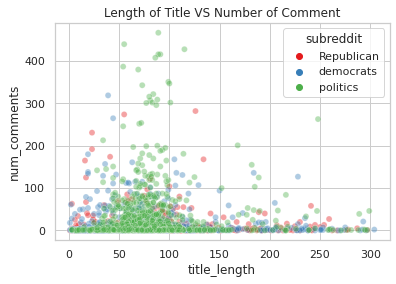

In [0]:
sns.scatterplot(
    data=sub_all_change_size, 
    x='title_length', 
    y='num_comments',
    hue="subreddit",
    alpha = .4).set(title = 'Length of Title VS Number of Comment')
plt.show()
#plt.savefig('data/plots/fig5.png')

##### 5F. Histogram of time vs. count of posts

This graph has shown the distribution of number of Reddit post in time hour of day. Each subreddit has the same sum of post, 20000. Similiar to the pattern of plot in 5B, the post of all three subreddits peaks at afternoon and reach bottom at morning. Republican subreddit has much higher post than other 2 subreddits from 12:00 to 16:00 while democrats subreddits has highest number of posts from 22:00 to 4:00.

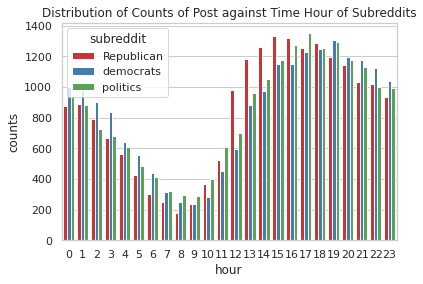

In [0]:
sns.set_theme(style="whitegrid", palette="Set1")
sns.barplot(
    data=sub_all_cnt, 
    #kind="bar",
    x="hour", 
    y="counts", 
    hue="subreddit").set(title='Distribution of Counts of Post against Time Hour of Subreddits')
plt.show()
#plt.savefig('data/plots/fig6.png')

The graph of number of comments verus time alone cannot well answer the buisiness question 1 and 2, 'How will we measure “engagement” on Reddit? In what ways do people interact with a post?' and 'When are the best times to post on Reddit to get the most engagement?', even though number of comments is a good indicator of engagement on Reddit, since the number of comments is related to number of posts. In order to avoid this issue, here creates a new variable the ratio of count of posts to the number of total comments at specific time hour and generates the plot below. All the three subreddits have similiar fluctuations on the ratio among the day. They all have relatively higher ratio from 11:00 to 17:00 and relatively lower ratio from 5:00 to 9:00. The answer to these business question is the best time to post on Reddit to get the most engagement is around afternoon time.

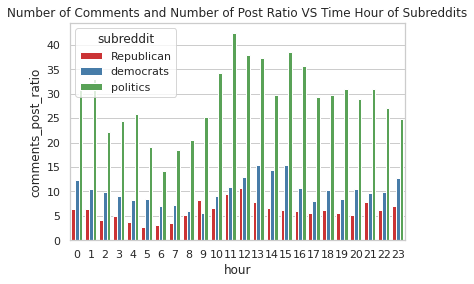

In [0]:
sns.set_theme(style="whitegrid", palette="Set1")
sns.barplot(
    data=sub_all_cnt, 
    x="hour", 
    y="comments_post_ratio", 
    hue="subreddit").set(title='Number of Comments and Number of Post Ratio VS Time Hour of Subreddits')
plt.show()
#plt.savefig('data/plots/fig7.png')
